# 线性回归的从零开始实现

在了解了线性回归的背景知识之后，现在我们可以动手实现它了。尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。因此，本节将介绍如何只利用`NDArray`和`autograd`来实现一个线性回归的训练。

首先，导入本节中实验所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示。

In [1]:
%matplotlib inline
import sys
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

## 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征$\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重$\boldsymbol{w} = [2, -3.4]^\top$和偏差$b = 4.2$，以及一个随机噪声项$\epsilon$来生成标签

$$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon,$$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [6]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
print(features)
print(features[:, 0])
print(labels)
print(labels.shape)



[[ 0.5035904  -1.189445  ]
 [-0.5502137  -1.5918756 ]
 [-1.1081946   0.07872018]
 ...
 [-1.348146    1.541968  ]
 [-2.2382517  -0.34891927]
 [ 0.02030805  1.09498   ]]
<NDArray 1000x2 @cpu(0)>

[ 5.03590405e-01 -5.50213695e-01 -1.10819459e+00 -9.18563485e-01
 -1.20808637e+00 -1.52274311e+00 -1.35493255e+00 -7.24855661e-01
 -4.78272468e-01 -7.92184651e-01 -3.15577412e+00 -5.38592100e-01
 -1.88151920e+00 -3.56015742e-01  1.79744768e+00 -1.73763990e+00
  1.45809308e-01  4.57878292e-01  4.93839443e-01 -1.21407938e+00
  1.09382212e+00 -1.04467010e+00  5.17420053e-01  1.37690091e+00
  9.94351864e-01  2.98818022e-01  3.51135463e-01  1.25943530e+00
  5.08050621e-01  1.68393016e+00  1.31232336e-01 -1.21380126e+00
 -5.68039775e-01 -1.20004416e+00 -1.53466478e-01 -7.53186285e-01
 -1.39981210e+00 -4.62191314e-01 -2.30282378e+00 -6.52319789e-01
 -2.76332438e-01  7.87935436e-01 -8.23990107e-01  1.53645948e-01
 -4.26477104e-01  1.17471194e+00  1.03841734e+00  6.77059531e-01
 -2.85893500e-01 -1.09106

注意，`features`的每一行是一个长度为2的向量，而`labels`的每一行是一个长度为1的向量（标量）。

In [3]:
features[0], labels[0]

(
 [2.2122064 0.7740038]
 <NDArray 2 @cpu(0)>, 
 [6.000587]
 <NDArray 1 @cpu(0)>)

通过生成第二个特征`features[:, 1]`和标签 `labels` 的散点图，可以更直观地观察两者间的线性关系。

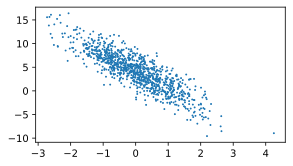

In [8]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(4.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);  # 加分号只显示图

我们将上面的`plt`作图函数以及`use_svg_display`函数和`set_figsize`函数定义在`d2lzh`包里。以后在作图时，我们将直接调用`d2lzh.plt`。由于`plt`在`d2lzh`包中是一个全局变量，我们在作图前只需要调用`d2lzh.set_figsize()`即可打印矢量图并设置图的尺寸。


## 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [29]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)  # take函数根据索引返回对应元素
a = nd.array([[1,2,3], [4,5,6], [7,8,9]])
c = a.take(nd.array([0,1]))
print(c)


[[1. 2. 3.]
 [4. 5. 6.]]
<NDArray 2x3 @cpu(0)>


让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [30]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[ 0.13123234  1.6403017 ]
 [ 1.3810002  -0.76296663]
 [-0.2103665  -2.2390873 ]
 [-2.0252197   0.14331104]
 [-1.1158241   0.2747542 ]
 [ 0.49884814  0.44148436]
 [ 1.5221801  -0.63030165]
 [-0.40239528 -0.29769737]
 [-0.39261648 -0.06174479]
 [-1.125028   -0.46906075]]
<NDArray 10x2 @cpu(0)> 
[-1.1091807   9.539722   11.38773    -0.34202975  1.0266986   3.681778
  9.356409    4.409488    3.6233795   3.5409849 ]
<NDArray 10 @cpu(0)>


## 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [34]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们需要创建它们的梯度。

In [35]:
w.attach_grad()
b.attach_grad()

## 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`dot`函数做矩阵乘法。

In [36]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return nd.dot(X, w) + b

## 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [37]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh包中方便以后使用
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

以下的`sgd`函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [38]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh包中方便以后使用
    for param in params:
        param[:] = param - lr * param.grad / batch_size

## 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失`l`的形状为(10, 1)。回忆一下[“自动求梯度”](../chapter_prerequisite/autograd.ipynb)一节。由于变量`l`并不是一个标量，运行`l.backward()`将对`l`中元素求和得到新的变量，再求该变量有关模型参数的梯度。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [42]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
            l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.000049
epoch 2, loss 0.000049
epoch 3, loss 0.000049


训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。

In [40]:
true_w, w

([2, -3.4], 
 [[ 1.9995877]
  [-3.4000142]]
 <NDArray 2x1 @cpu(0)>)

In [41]:
true_b, b

(4.2, 
 [4.200264]
 <NDArray 1 @cpu(0)>)

## 小结

* 可以看出，仅使用`NDArray`和`autograd`模块就可以很容易地实现一个模型。接下来，本书会在此基础上描述更多深度学习模型，并介绍怎样使用更简洁的代码（见下一节）来实现它们。


## 练习

* 为什么`squared_loss`函数中需要使用`reshape`函数？
* 尝试使用不同的学习率，观察损失函数值的下降快慢。
* 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？




## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/743)

![](../img/qr_linear-regression-scratch.svg)